## Import Data

In [1]:
library(dplyr)
aapl <- read.csv(file="../input/stocks2018/AAPL.csv", sep=",", header = TRUE , colClasses=c("Date", "numeric", "numeric", "numeric", "numeric", "numeric", "numeric"))
amzn <- read.csv(file="../input/stocks2018/AMZN.csv", sep=",", header = TRUE , colClasses=c("Date", "numeric", "numeric", "numeric", "numeric", "numeric", "numeric"))
fb <- read.csv(file="../input/stocks2018/FB.csv", sep=",", header = TRUE , colClasses=c("Date", "numeric", "numeric", "numeric", "numeric", "numeric", "numeric"))
goog <- read.csv(file="../input/stocks2018/GOOG.csv", sep=",", header = TRUE , colClasses=c("Date", "numeric", "numeric", "numeric", "numeric", "numeric", "numeric"))
ibm <- read.csv(file="../input/stocks2018/IBM.csv", sep=",", header = TRUE , colClasses=c("Date", "numeric", "numeric", "numeric", "numeric", "numeric", "numeric"))
msft <- read.csv(file="../input/stocks2018/MSFT.csv", sep=",", header = TRUE , colClasses=c("Date", "numeric", "numeric", "numeric", "numeric", "numeric", "numeric"))
nflx <- read.csv(file="../input/stocks2018/NFLX.csv", sep=",", header = TRUE , colClasses=c("Date", "numeric", "numeric", "numeric", "numeric", "numeric", "numeric"))
orcl <- read.csv(file="../input/stocks2018/ORCL.csv", sep=",", header = TRUE , colClasses=c("Date", "numeric", "numeric", "numeric", "numeric", "numeric", "numeric"))
sap <- read.csv(file="../input/stocks2018/SAP.csv", sep=",", header = TRUE , colClasses=c("Date", "numeric", "numeric", "numeric", "numeric", "numeric", "numeric"))
tsla <- read.csv(file="../input/stocks2018/TSLA.csv", sep=",", header = TRUE , colClasses=c("Date", "numeric", "numeric", "numeric", "numeric", "numeric", "numeric"))
jpyusd <- read.csv(file="../input/jypusd-2018csv/JYP-USD_2018.csv", sep=",", header = TRUE, colClasses=c("Date", "numeric", "numeric", "numeric", "numeric", "numeric", "numeric"))
jpyusd <- jpyusd[with(jpyusd, order(Date)),]
stocks = list(
    AAPL = aapl,
    AMZN = amzn,
    FB = fb,
    GOOG = goog,
    IBM = ibm,
    MSFT = msft,
    NFLX = nflx,
    ORCL = orcl,
    SAP = sap,
    TSLA = tsla
)
dates <- aapl$"Date"


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Function to convert USD to JPY on a certain date

In [2]:
USDtoJPY <- function(dollar, daate){
    yen = dollar * (jpyusd[which(jpyusd$Date == daate), "Close"])
    return(yen)
}

## Find dividend payouts

In [3]:
findRatio = function(df){
    todaydf = df[c('Close','Adj.Close')]
    yesterdaydf = lag(df[c('Close','Adj.Close')], k = 1)
    ratiodf = yesterdaydf/todaydf
    names(ratiodf)[names(ratiodf)=="Close"] <- "CloseRatio"
    names(ratiodf)[names(ratiodf)=="Adj.Close"] <- "AdjCloseRatio"
    return(ratiodf)
}
findDividendAmounts = function(dflist){
    newList = list()
    for(stockname in names(dflist)){
        df = dflist[[stockname]]
        x = findRatio(df)
        z = cbind(Date = df["Date"], df["Close"], x)
        z$DivedendAmount = with(z, (Close * abs(AdjCloseRatio-CloseRatio)))
        z[is.na(z)] <- 0
        newList[[stockname]] = df
        newList[[stockname]]$DivedendAmount = round(z$DivedendAmount, 2)
    }
    return(newList)
}
stocks = findDividendAmounts(stocks)

## Dividend Amount * # of shares on divend date

In [4]:
findDividendAmountForShares = function(dfSharesOwned){
#     dfSharesOwned looks like this:
#     | date |  AAPL  |    AMZN      |  FB    |    GOOG      |  IBM   |     MSFT     |   NFLX |      ORCL    |   SAP  |     TSLA     |
#     goes from 1st Jan to 31st Dec
    
    dividendPayouts = as.data.frame(cbind('Date'= dfSharesOwned['Date'], "AAPL" = 0, "AMZN" = 0, "FB" = 0, "GOOG" = 0, "IBM" = 0, "MSFT" = 0, "NFLX" = 0, "ORCL" = 0, "SAP" = 0, "TSLA" = 0))
    for(colName in names(dividendPayouts)){
        if(colName == "Date"){
            next
        }
        dividendPayouts[colName] <- dfSharesOwned[colName] * stocks[[colName]]["DivedendAmount"]
    }
#     returns a dataframe that looks like this:
#     | date |  AAPL  |    AMZN      |  FB    |    GOOG      |  IBM   |     MSFT     |   NFLX |      ORCL    |   SAP  |     TSLA     |
#     goes from 1st Jan to 31st Dec
#     contains the earning from the dividend payouts
#     it is possible to get just a single int if needed that sums them all up
    return(dividendPayouts)
}

findDividendAmountForSharesOnDate = function(row, daate){
#     row is a vector with name:value pairs
#     row should have all the stocks (AAPL, AMZN, etc.) as the name and the value will be the number of shares owned that day for each of the stocks
    total = 0
    for(stockname in names(row)){
        x <- stocks[[stockname]]
        y <- x[which(x$Date == daate), "DivedendAmount"]
        total = total + ( row[stockname] * y )
    }
#     returns the total earned that date from stock dividend payouts
    return(total)
}

## Calculate High Tech Index

In [5]:
highTechIndexDF = function(){
    dfCloseVals <- as.data.frame(cbind("AAPL" = aapl["Close"],
                                       "AMZN" = amzn["Close"], "FB" = fb["Close"], "GOOG" = goog["Close"],
                                       "IBM" = ibm["Close"], "MSFT" = ibm["Close"], "NFLX" = nflx["Close"], "ORCL" = orcl["Close"],
                                       "SAP" = sap["Close"], "TSLA" = tsla["Close"]
                                      )
                                )
    names(dfCloseVals) = c("AAPL", "AMZN", "FB", "GOOG", "IBM", "MSFT", "NFLX", "ORCL", "SAP", "TSLA")
    dfCloseVals$HighTechIndex <- with(dfCloseVals,apply(dfCloseVals,1,mean,na.rm = TRUE))
    dfCloseVals <- cbind("Date" = dates, "HighTechIndex" = dfCloseVals["HighTechIndex"])
    return(dfCloseVals)
}

## Plot MTM and HighTechIndex vs Date

In [6]:
plotMTMHTIF = function(mtm_dfhigh, mtm_dflow,hti_df){
    plot(hti_df$Date, hti_df$"HighTechIndex%change", type="l", col = "blue", xlab="", ylab="")
    lines(mtm_dfhigh$Date, mtm_dfhigh$"MTM%change", col="red", xlab="", ylab="")
    lines(mtm_dflow$Date, mtm_dflow$"MTM%change", col="green", xlab="", ylab="")
    title(main="Percentage Change vs Date", xlab="Date", ylab="% Change") 
    legend(x = "topleft", box.lty = 0, legend = c("HighTechIndex", "MTMhighStrat", "MTMlowStrat"), col = c("blue", "red", "green"), lty = c(1, 1, 1), text.font=4)
}

## Calculate % difference
% difference = ((new - old) / old) * 100

In [7]:
percentDiff <- function(df, collname){
    newColName <- paste(collname, "%change", sep="")
    rtn <- cbind.data.frame(
        df,
        "%change" = 0.00
    )
    ori = df[1, collname]
    for(index in 2:nrow(df)){
        ch = 0.00
        if(ori != 0.00){
            ch = ((df[index, collname] - ori )/ ori) * 100.0
        }
        rtn[index, "%change"] <- ch
    }
    return(rtn)
}

## MTM and High & Low Rebalance

In [8]:
lowRebalance <- function(slice, days){
    #calculate portfolio
    cash = calculateMTM(slice)
#     cash = slice$MTM
    start = dates[match(as.Date(slice$Date), dates) - days]
    end = slice$Date
    values = sapply(seq_along(stocks), function(x){
        stock = as.data.frame(stocks[x])
        getChange(stock, start, end)
    })
    sorted_values = sort(values, decreasing=FALSE)[1:5]
    indexes = match(sorted_values, values)
    per_stock = cash / 5
    cash = 0
    stock_list = sapply(c(1:10), function(index){
        if(index %in% indexes){
            stock = as.data.frame(stocks[index])
            close = as.double(stock[stock[1] == toString(end)][5])
            stocks = as.integer(per_stock/close)
            cash <<- cash + (per_stock - (stocks * close))
            return(stocks)
        }else{
            return(0)
        }
    })
    return_frame = as.data.frame(cbind.data.frame(
        "Date" = dates[match(as.Date(end), dates) + 1],
        "AAPL" = stock_list[1],
        "AMZN" = stock_list[2],
        "FB" = stock_list[3],
        "GOOG" = stock_list[4],
        "IBM" = stock_list[5],
        "MSFT" = stock_list[6],
        "NFLX" = stock_list[7],
        "ORCL" = stock_list[8],
        "SAP" = stock_list[9],
        "TSLA" = stock_list[10],
        "LiquidCash" = cash,
        "MTM" = 0,
        "MTMtoYen" = 0
    ))
    
    return(return_frame)
}

highRebalance <- function(slice, days){
    #calculate portfolio
    cash = calculateMTM(slice)
    start = dates[match(as.Date(slice$Date), dates) - days]
    end = slice$Date
    values = sapply(seq_along(stocks), function(x){
        stock = as.data.frame(stocks[x])
        getChange(stock, start, end)
    })
    sorted_values = sort(values, decreasing=TRUE)[1:5]
    indexes = match(sorted_values, values)
    per_stock = cash / 5
    cash = 0
    stock_list = sapply(c(1:10), function(index){
        if(index %in% indexes){
            stock = as.data.frame(stocks[index])
            close = as.double(stock[stock[1] == toString(end)][5])
            stocks = as.integer(per_stock/close)
            cash <<- cash + (per_stock - (stocks * close))
            return(stocks)
        }else{
            return(0)
        }
    })
    return_frame = as.data.frame(cbind.data.frame(
        "Date" = dates[match(as.Date(end), dates) + 1],
        "AAPL" = stock_list[1],
        "AMZN" = stock_list[2],
        "FB" = stock_list[3],
        "GOOG" = stock_list[4],
        "IBM" = stock_list[5],
        "MSFT" = stock_list[6],
        "NFLX" = stock_list[7],
        "ORCL" = stock_list[8],
        "SAP" = stock_list[9],
        "TSLA" = stock_list[10],
        "LiquidCash" = cash,
        "MTM" = 0,
        "MTMtoYen" = 0
    ))
    
    return(return_frame)
}

calculateMTM <- function(slice){
    cash = as.double(slice$LiquidCash)
    stock_value = sum(sapply(seq_along(slice[2:11]), function(x){
        df = as.data.frame(stocks[x])
        close_price = as.double(df[df[1] == toString(slice$Date)][5])
        return(close_price * as.integer(slice[x+1]))
    }))
    return(stock_value + cash)
}

getChange <- function(stock, start, end){
    start_price = as.double(stock[stock[1] == toString(start)][6])
    end_price = as.double(stock[stock[1] == toString(end)][6])
    
    return(end_price - start_price)
}

## Main Loop

In [9]:
closePriceOnDate = function(stock, daate){
    df <- stocks[[stock]]
    rtn = df[which(df$Date == daate),"Close"]
    return(rtn)
}

howManySharesInMoney = function(stock, money, daate){
    rtn = as.integer((money) / closePriceOnDate(stock, daate))
    return(rtn)
}

computeEntireYear = function(givenCash = 5000000, refactorEveryXDays = 5, initInvestmentShares = c("AAPL", "AMZN", "GOOG", "IBM", "MSFT")){
#     This function will be the main thing that controls the program
#     function will iterate over each date, and call high buy, low buy, findDividendAmountForSharesOnDate, calculateMTM every day
#     function will call convertMTMYen at the end of the year and the plot the curve as well
#     function will return two dataframes in a list/vector and they just need to be outputed
    
    start_date = dates[1]
    end_date = dates[match(start_date, dates) + refactorEveryXDays]
    
#     before loop do a split of the given cash
    highDF <- as.data.frame(cbind.data.frame("Date" = as.Date(dates),
                                             "AAPL" = 0,
                                             "AMZN" = 0,
                                             "FB" = 0,
                                             "GOOG" = 0,
                                             "IBM" = 0,
                                             "MSFT" = 0,
                                             "NFLX" = 0,
                                             "ORCL" = 0,
                                             "SAP" = 0,
                                             "TSLA" = 0,
                                             "LiquidCash" = 0,
                                             "MTM" = 0,
                                             "MTMtoYen" = 0
                                            )
                           )
    lowDF <- as.data.frame(cbind.data.frame("Date" = as.Date(dates),
                                             "AAPL" = 0,
                                             "AMZN" = 0,
                                             "FB" = 0,
                                             "GOOG" = 0,
                                             "IBM" = 0,
                                             "MSFT" = 0,
                                             "NFLX" = 0,
                                             "ORCL" = 0,
                                             "SAP" = 0,
                                             "TSLA" = 0,
                                             "LiquidCash" = 0,
                                             "MTM" = 0,
                                             "MTMtoYen" = 0
                                            )
                           )
    
    remCash = 0
    
#     Invest in the initial given shares    
    for(stck in initInvestmentShares){
        shrs = howManySharesInMoney(stck, ((1 / length(initInvestmentShares)) * givenCash), start_date)
        remCash = remCash + (((1 / length(initInvestmentShares)) * givenCash) - (shrs * closePriceOnDate(stck, start_date)))
        highDF[which(highDF$Date == start_date), stck] <- shrs
        lowDF[which(lowDF$Date == start_date), stck] <- shrs
    }
    
    remCash = round(remCash, 2)
    highDF[which(highDF$Date == start_date), "LiquidCash"] <- remCash
    lowDF[which(lowDF$Date == start_date), "LiquidCash"] <- remCash
    
    for(current_index in 1:length(dates)){
        current_date = dates[current_index]
#         begining of iteration
        

#         do dividend stuff here
        cashFromDividendHigh = findDividendAmountForSharesOnDate(highDF[which(highDF$Date == current_date), ][c("AAPL", "AMZN", "FB", "GOOG", "IBM", "MSFT", "NFLX", "ORCL", "SAP", "TSLA")], current_date)
        cashFromDividendLow = findDividendAmountForSharesOnDate(lowDF[which(lowDF$Date == current_date), ][c("AAPL", "AMZN", "FB", "GOOG", "IBM", "MSFT", "NFLX", "ORCL", "SAP", "TSLA")], current_date)
        
        highDF[which(highDF$Date == current_date), "LiquidCash"] <- highDF[which(highDF$Date == current_date), "LiquidCash"] + cashFromDividendHigh
        lowDF[which(lowDF$Date == current_date), "LiquidCash"] <- lowDF[which(lowDF$Date == current_date), "LiquidCash"] + cashFromDividendLow
        
        
#         do mtm stuff here
        todaysHighMTM = calculateMTM(highDF[which(highDF$Date == current_date), ])
        todaysLowMTM = calculateMTM(lowDF[which(lowDF$Date == current_date), ])
        
        highDF[which(highDF$Date == current_date), "MTM"] <- todaysHighMTM
        lowDF[which(lowDF$Date == current_date), "MTM"] <- todaysLowMTM
        
#         Do MTMtoYen stuff here
        highDF[which(highDF$Date == current_date), "MTMtoYen"] <- USDtoJPY(highDF[which(highDF$Date == current_date), "MTM"], current_date)
        lowDF[which(lowDF$Date == current_date), "MTMtoYen"] <- USDtoJPY(lowDF[which(lowDF$Date == current_date), "MTM"], current_date)
        
#         end of iteration stuff
        if(current_date == end_date){
            
            if(current_index != length(dates)){
#                 high and low rebalance
                tomorrow_date = dates[current_index + 1]
                highDF[which(highDF$Date == tomorrow_date),] <- highRebalance(highDF[which(highDF$Date == current_date),], refactorEveryXDays)
                lowDF[which(lowDF$Date == tomorrow_date),] <- lowRebalance(lowDF[which(lowDF$Date == current_date),], refactorEveryXDays)
            }
            
            start_date = end_date
            if(current_index + refactorEveryXDays <= length(dates)){
                end_date = dates[current_index + refactorEveryXDays]
            }
            else{
                if(current_index != length(dates)){
                    end_date = dates[length(dates)]
                }
            }
        }
        else{
#             We are not at the end of the dates yet
            tomorrow_date = dates[current_index + 1]
            highDF[which(highDF$Date == tomorrow_date),][c("AAPL", "AMZN", "FB", "GOOG", "IBM", "MSFT", "NFLX", "ORCL", "SAP", "TSLA", "LiquidCash")] <- highDF[which(highDF$Date == current_date),][c("AAPL", "AMZN", "FB", "GOOG", "IBM", "MSFT", "NFLX", "ORCL", "SAP", "TSLA", "LiquidCash")]
            lowDF[which(lowDF$Date == tomorrow_date),][c("AAPL", "AMZN", "FB", "GOOG", "IBM", "MSFT", "NFLX", "ORCL", "SAP", "TSLA", "LiquidCash")] <- lowDF[which(lowDF$Date == current_date),][c("AAPL", "AMZN", "FB", "GOOG", "IBM", "MSFT", "NFLX", "ORCL", "SAP", "TSLA", "LiquidCash")]
        }
    }
#     return
    lowDF <- percentDiff(lowDF, "MTM")
    names(lowDF)[names(lowDF)=="%change"] <- "MTM%change"
    highDF <- percentDiff(highDF, "MTM")
    names(highDF)[names(highDF)=="%change"] <- "MTM%change"
    rtn <- list(
        "LowBalanceStrategy" = lowDF,
        "HighBalanceStrategy" = highDF
    )
    return(rtn)
}

## Making Observations

In [10]:
HTI <- percentDiff(highTechIndexDF(), "HighTechIndex")
names(HTI)[names(HTI)=="%change"] <- "HighTechIndex%change"

Date,AAPL,AMZN,FB,GOOG,IBM,MSFT,NFLX,ORCL,SAP,TSLA,LiquidCash,MTM,MTMtoYen,MTM%change
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-02,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5000000,561435006,0.00000000
2018-01-03,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5061134,569418088,1.22268319
2018-01-04,23508,0,0,0,0,11722,0,21216,8933,15953,112.3600,5091868,574103047,1.83736282
2018-01-05,23542,0,5524,0,0,0,4952,21136,0,16184,286.9510,5151447,582396885,3.02894687
2018-01-08,23549,0,0,0,6340,11682,0,21256,0,16272,200.1930,5230261,591490168,4.60521044
2018-01-09,23998,0,0,0,6399,11849,0,21356,9111,0,4271.4595,5231668,589347441,4.63336624
2018-01-10,0,0,5569,945,0,0,4998,0,9165,15678,1278.4905,5235753,583404282,4.71506476
2018-01-11,0,0,5574,949,0,11923,0,21458,9277,0,1032.9905,5214479,580204613,4.28957237
2018-01-12,23799,0,5554,0,6351,0,0,21305,9512,0,122.2805,5188454,576136280,3.76907372


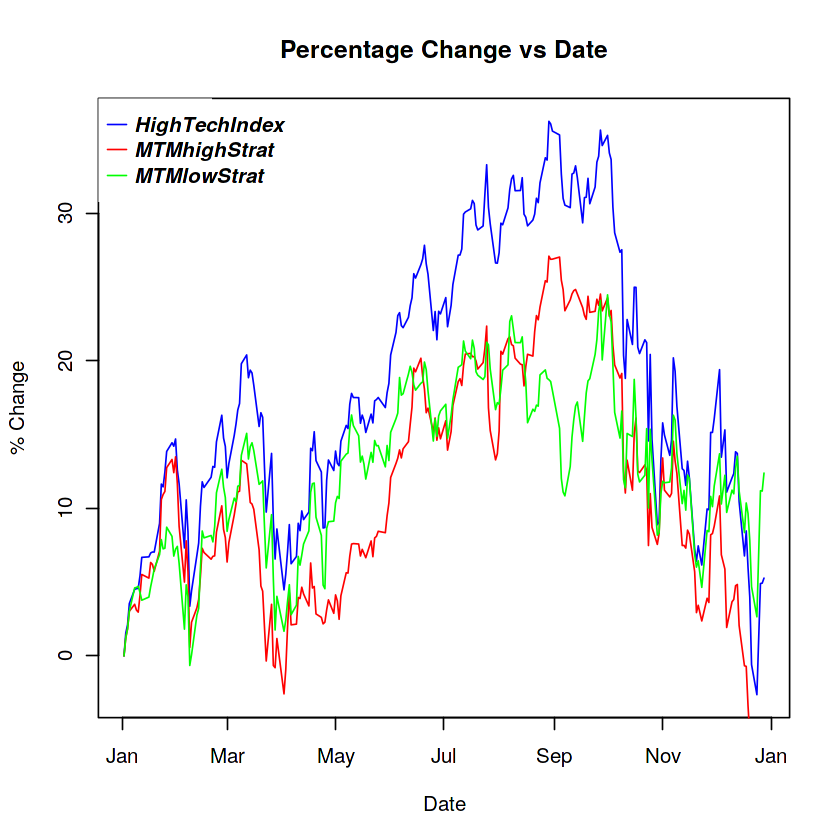

In [11]:
val <- computeEntireYear(givenCash = 5000000, refactorEveryXDays = 1)
val
plotMTMHTIF(val[["HighBalanceStrategy"]], val[["LowBalanceStrategy"]], HTI)

Date,AAPL,AMZN,FB,GOOG,IBM,MSFT,NFLX,ORCL,SAP,TSLA,LiquidCash,MTM,MTMtoYen,MTM%change
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-02,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5000000,561435006,0.0000000
2018-01-03,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5061134,569418088,1.2226832
2018-01-04,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5103637,575429993,2.0727434
2018-01-05,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5164049,583821521,3.2809722
2018-01-08,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5187004,586598253,3.7400738
2018-01-09,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5192788,584967603,3.8557652
2018-01-10,23829,0,0,0,0,11772,0,21169,9097,15561,160.3995,5174057,576529615,3.4811328
2018-01-11,23829,0,0,0,0,11772,0,21169,9097,15561,160.3995,5166611,574878424,3.3322102
2018-01-12,23829,0,0,0,0,11772,0,21169,9097,15561,160.3995,5206215,578108491,4.1242927


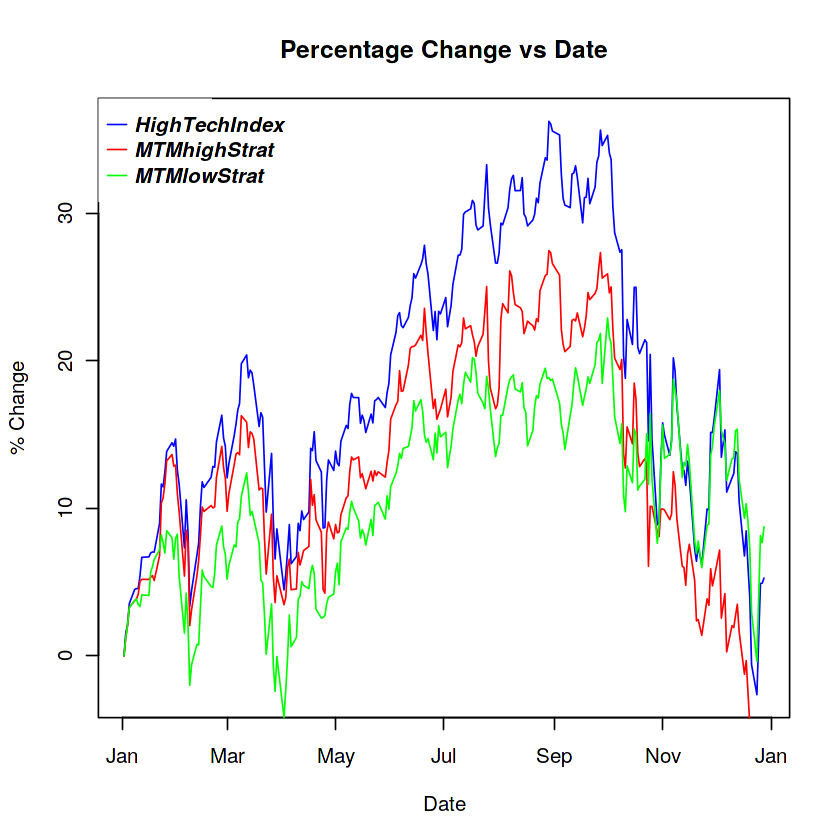

In [12]:
val <- computeEntireYear(givenCash = 5000000, refactorEveryXDays = 5)
val
plotMTMHTIF(val[["HighBalanceStrategy"]], val[["LowBalanceStrategy"]], HTI)

Date,AAPL,AMZN,FB,GOOG,IBM,MSFT,NFLX,ORCL,SAP,TSLA,LiquidCash,MTM,MTMtoYen,MTM%change
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-02,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5000000,561435006,0.0000000
2018-01-03,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5061134,569418088,1.2226832
2018-01-04,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5103637,575429993,2.0727434
2018-01-05,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5164049,583821521,3.2809722
2018-01-08,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5187004,586598253,3.7400738
2018-01-09,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5192788,584967603,3.8557652
2018-01-10,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5188118,578096462,3.7623658
2018-01-11,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5218546,580657143,4.3709130
2018-01-12,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5279553,586252119,5.5910579


Date,AAPL,AMZN,FB,GOOG,IBM,MSFT,NFLX,ORCL,SAP,TSLA,LiquidCash,MTM,MTMtoYen,MTM%change
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-02,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5000000,561435006,0.0000000
2018-01-03,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5061134,569418088,1.2226832
2018-01-04,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5103637,575429993,2.0727434
2018-01-05,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5164049,583821521,3.2809722
2018-01-08,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5187004,586598253,3.7400738
2018-01-09,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5192788,584967603,3.8557652
2018-01-10,23829,0,0,0,0,11772,0,21169,9097,15561,160.3995,5174057,576529615,3.4811328
2018-01-11,23829,0,0,0,0,11772,0,21169,9097,15561,160.3995,5166611,574878424,3.3322102
2018-01-12,23829,0,0,0,0,11772,0,21169,9097,15561,160.3995,5206215,578108491,4.1242927


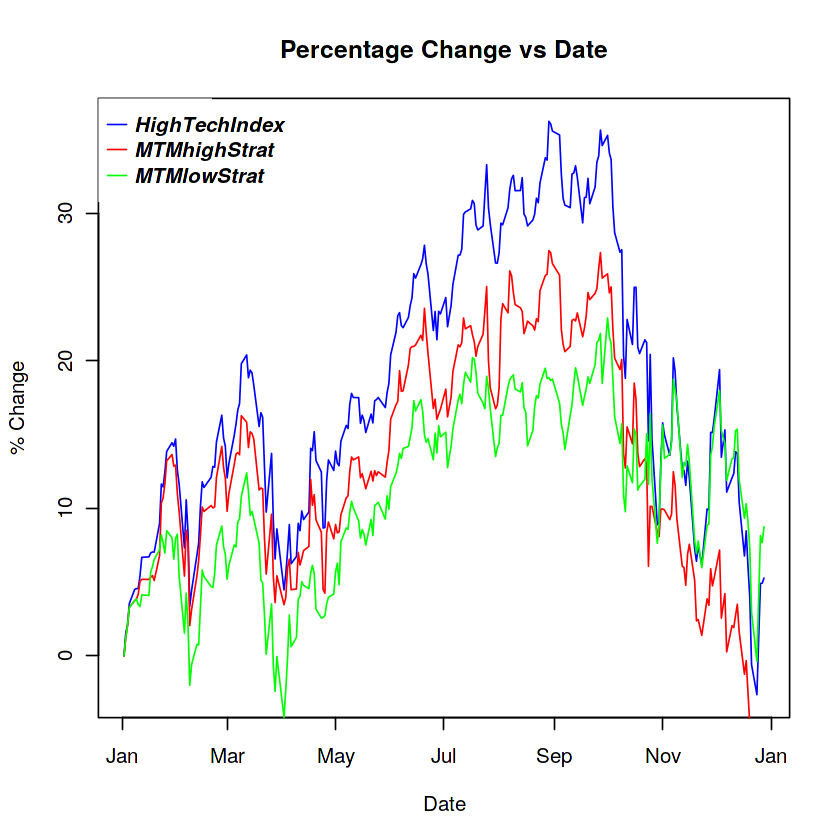

In [13]:
computeEntireYear(givenCash = 5000000, refactorEveryXDays = 10)
val
plotMTMHTIF(val[["HighBalanceStrategy"]], val[["LowBalanceStrategy"]], HTI)

Date,AAPL,AMZN,FB,GOOG,IBM,MSFT,NFLX,ORCL,SAP,TSLA,LiquidCash,MTM,MTMtoYen,MTM%change
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-02,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5000000,561435006,0.00000000
2018-01-03,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5061134,569418088,1.22268319
2018-01-04,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5103637,575429993,2.07274338
2018-01-05,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5164049,583821521,3.28097217
2018-01-08,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5187004,586598253,3.74007376
2018-01-09,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5192788,584967603,3.85576516
2018-01-10,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5188118,578096462,3.76236576
2018-01-11,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5218546,580657143,4.37091296
2018-01-12,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5279553,586252119,5.59105794


Date,AAPL,AMZN,FB,GOOG,IBM,MSFT,NFLX,ORCL,SAP,TSLA,LiquidCash,MTM,MTMtoYen,MTM%change
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-02,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5000000,561435006,0.0000000
2018-01-03,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5061134,569418088,1.2226832
2018-01-04,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5103637,575429993,2.0727434
2018-01-05,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5164049,583821521,3.2809722
2018-01-08,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5187004,586598253,3.7400738
2018-01-09,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5192788,584967603,3.8557652
2018-01-10,23829,0,0,0,0,11772,0,21169,9097,15561,160.3995,5174057,576529615,3.4811328
2018-01-11,23829,0,0,0,0,11772,0,21169,9097,15561,160.3995,5166611,574878424,3.3322102
2018-01-12,23829,0,0,0,0,11772,0,21169,9097,15561,160.3995,5206215,578108491,4.1242927


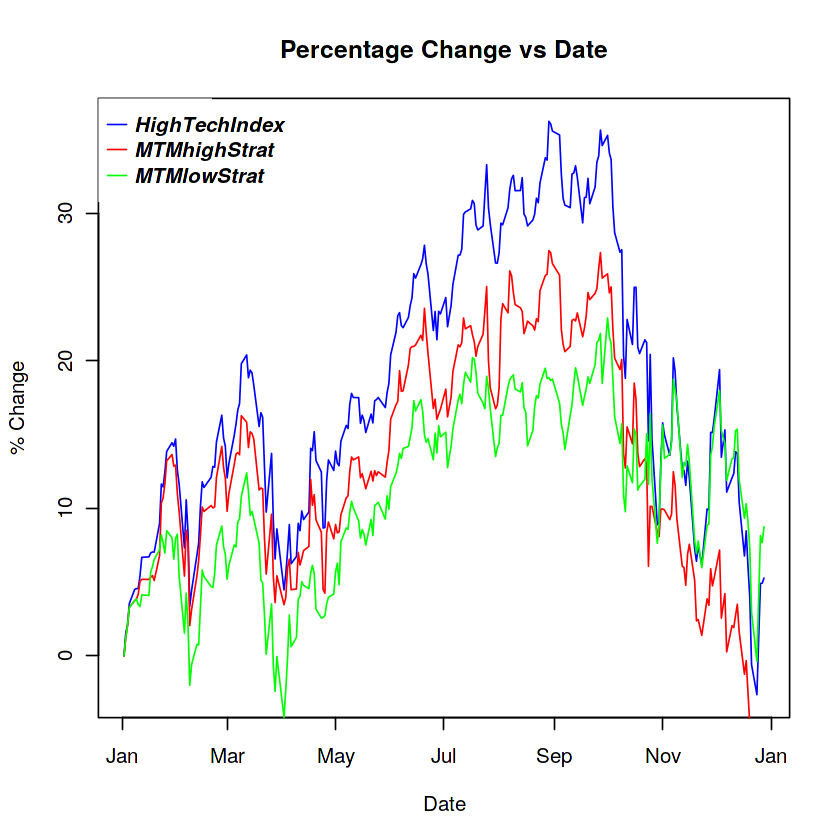

In [14]:
computeEntireYear(givenCash = 5000000, refactorEveryXDays = 20)
val
plotMTMHTIF(val[["HighBalanceStrategy"]], val[["LowBalanceStrategy"]], HTI)

Date,AAPL,AMZN,FB,GOOG,IBM,MSFT,NFLX,ORCL,SAP,TSLA,LiquidCash,MTM,MTMtoYen,MTM%change
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-02,23220,841,0,938,6482,11634,0,0,0,0,1312.54,5000000,561435006,0.0000000
2018-01-03,23220,841,0,938,6482,11634,0,0,0,0,1312.54,5061134,569418088,1.2226832
2018-01-04,23220,841,0,938,6482,11634,0,0,0,0,1312.54,5103637,575429993,2.0727434
2018-01-05,23220,841,0,938,6482,11634,0,0,0,0,1312.54,5164049,583821521,3.2809722
2018-01-08,23220,841,0,938,6482,11634,0,0,0,0,1312.54,5187004,586598253,3.7400738
2018-01-09,23220,841,0,938,6482,11634,0,0,0,0,1312.54,5192788,584967603,3.8557652
2018-01-10,23220,841,0,938,6482,11634,0,0,0,0,1312.54,5188118,578096462,3.7623658
2018-01-11,23220,841,0,938,6482,11634,0,0,0,0,1312.54,5218546,580657143,4.3709130
2018-01-12,23220,841,0,938,6482,11634,0,0,0,0,1312.54,5279553,586252119,5.5910579


Date,AAPL,AMZN,FB,GOOG,IBM,MSFT,NFLX,ORCL,SAP,TSLA,LiquidCash,MTM,MTMtoYen,MTM%change
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-02,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5000000,561435006,0.0000000
2018-01-03,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5061134,569418088,1.2226832
2018-01-04,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5103637,575429993,2.0727434
2018-01-05,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5164049,583821521,3.2809722
2018-01-08,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5187004,586598253,3.7400738
2018-01-09,23220,841,0,938,6482,11634,0,0,0,0,1312.5400,5192788,584967603,3.8557652
2018-01-10,23829,0,0,0,0,11772,0,21169,9097,15561,160.3995,5174057,576529615,3.4811328
2018-01-11,23829,0,0,0,0,11772,0,21169,9097,15561,160.3995,5166611,574878424,3.3322102
2018-01-12,23829,0,0,0,0,11772,0,21169,9097,15561,160.3995,5206215,578108491,4.1242927


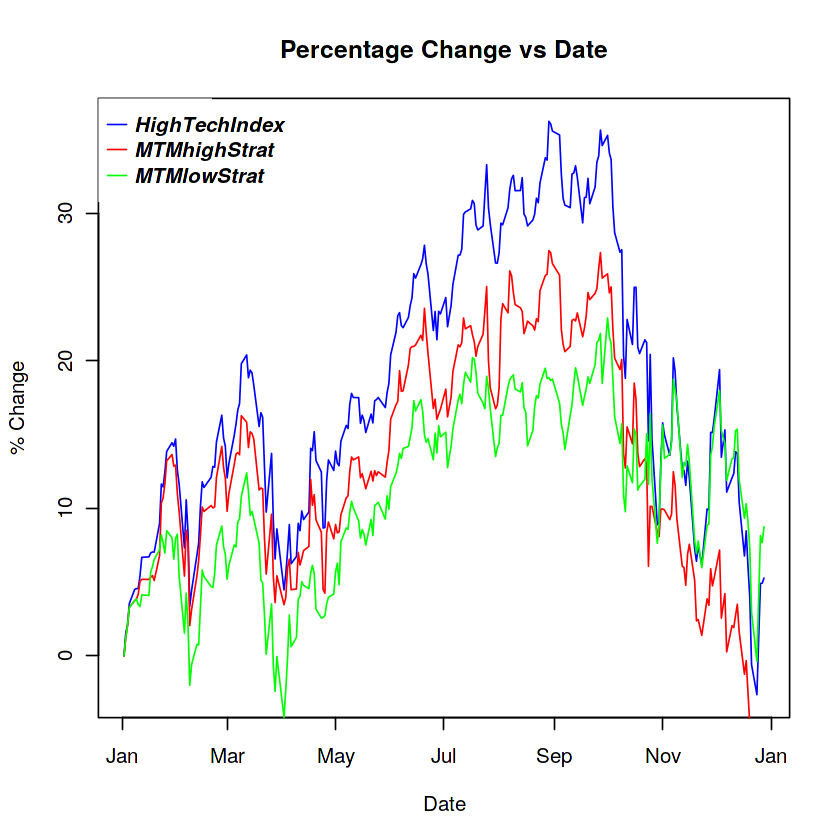

In [15]:
computeEntireYear(givenCash = 5000000, refactorEveryXDays = 50)
val
plotMTMHTIF(val[["HighBalanceStrategy"]], val[["LowBalanceStrategy"]], HTI)